# EC-A1
### Jing Qian (jq2282)

# EC1. Write a custom loss function.
Provide your own implementation of a squared error loss function, and run an experiment to compare it to cross entropy. What do you find?

Reference: given example: https://github.com/random-forests/applied-dl/blob/master/examples/2.3-custom-loss.ipynb

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190502


In [0]:
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import relu

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

# Types are needed later when calculating loss
# using the ```sparse_softmax_cross_entropy_with_logits``` we chose to 
# compare against.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [0]:
BATCH_SIZE = 128
BUFFER_SIZE = len(x_train)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [0]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(128)
    self.d2 = Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = relu(x)
    x = self.d2(x)
    return x 
  
model = MyModel()
optimizer = tf.keras.optimizers.Adam()

In [0]:
def built_in_loss(logits, labels):
  return tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=labels))

In [0]:
def our_loss(logits, labels, n_classes=10):  
  # logits are predicted.
  labels = tf.one_hot(labels, n_classes, dtype=tf.float32)
  return tf.reduce_mean(tf.pow(tf.subtract(logits, labels), 2))

In [0]:
def train_on_batch(model, images, labels):
  with tf.GradientTape() as tape:
    # Forward pass
    logits = model(images)
    loss_one = built_in_loss(logits, labels)
    loss_two = our_loss(logits, labels)    
    
  # Backward pass
  # I'll use our implementation to update the gradients.
  grads = tape.gradient(loss_two, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables))
  return loss_one, loss_two

In [0]:
# Low-level code ahead. 
# See the above note for a better way of  calculating accuracy in practice.
def calc_accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1)
  batch_size = int(logits.shape[0])
  acc = tf.reduce_sum(
      tf.cast(tf.equal(predictions, labels), dtype=tf.float32)) / batch_size
  return acc * 100

In [11]:

# Loop over the dataset, grab batchs, and train our model
# As we go, verify the loss returned by our implementation is
# the same as the built-in methods.

EPOCHS = 5

for epoch in range(EPOCHS):
  print("Epoch", epoch + 1, "\n")
  for (batch, (images, labels)) in enumerate(train_dataset):
    loss_one, loss_two = train_on_batch(model, images, labels)
    
    # You can use something like this as a quick sanity check
    #tf.debugging.assert_near(loss_one, loss_two, atol=0.001, rtol=0.001)
    
    step = optimizer.iterations.numpy() 
    if step % 100 == 0:
      print("Step", step)
      print("Built-in loss: %.4f, Our loss: %.4f" % (loss_one.numpy(), loss_two.numpy()))
      print("")
      
  print('Train accuracy %.2f' % calc_accuracy(model(x_train), y_train))
  print('Test accuracy %.2f\n' % calc_accuracy(model(x_test), y_test))

Epoch 1 

Step 100
Built-in loss: 1.7134, Our loss: 0.0282

Step 200
Built-in loss: 1.6518, Our loss: 0.0243

Step 300
Built-in loss: 1.6193, Our loss: 0.0174

Step 400
Built-in loss: 1.6148, Our loss: 0.0171

Train accuracy 94.77
Test accuracy 94.82

Epoch 2 

Step 500
Built-in loss: 1.5983, Our loss: 0.0171

Step 600
Built-in loss: 1.6125, Our loss: 0.0164

Step 700
Built-in loss: 1.5674, Our loss: 0.0136

Step 800
Built-in loss: 1.5738, Our loss: 0.0136

Step 900
Built-in loss: 1.5729, Our loss: 0.0145

Train accuracy 96.20
Test accuracy 95.83

Epoch 3 

Step 1000
Built-in loss: 1.5836, Our loss: 0.0111

Step 1100
Built-in loss: 1.5803, Our loss: 0.0131

Step 1200
Built-in loss: 1.5892, Our loss: 0.0125

Step 1300
Built-in loss: 1.5434, Our loss: 0.0096

Step 1400
Built-in loss: 1.5759, Our loss: 0.0108

Train accuracy 96.93
Test accuracy 96.32

Epoch 4 

Step 1500
Built-in loss: 1.5916, Our loss: 0.0149

Step 1600
Built-in loss: 1.5807, Our loss: 0.0125

Step 1700
Built-in loss: 1.

### Findings: 
Our squared error loss has much smaller value magnitude than the built-in SparseCategoricalCrossentropy loss. 
Moverover, comparing to the result of Assignment 1 with built-in loss, the two loss functions lead to similar training and validation accuracy.
It seems that we may use squared error loss function for classification task.

# EC2. Provide your own implementation of a Dense layer.

Reference: given example: https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/eager/custom_layers.ipynb

In [0]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_variable("kernel",
                                    shape=[int(input_shape[-1]),
                                           self.num_outputs])

  def call(self, input):
    return tf.matmul(input, self.kernel)
  
# layer = MyDenseLayer(10)
# print(layer(tf.zeros([10, 5])))
# print(layer.trainable_variables)

In [0]:
class ModelWithCustomLayer(Model):
  def __init__(self):
    super(ModelWithCustomLayer, self).__init__()
    self.flatten = Flatten()
    self.d1 = MyDenseLayer(128)
    self.d2 = MyDenseLayer(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = relu(x)
    x = self.d2(x)
    return x 
  
custom_layer_model = ModelWithCustomLayer()
regular_layer_model = MyModel()
optimizer = tf.keras.optimizers.Adam()

In [16]:
EPOCHS = 5
print("Model with built-in Dense Layers")
for epoch in range(EPOCHS):
  print("Epoch", epoch + 1, "\n")
  for (batch, (images, labels)) in enumerate(train_dataset):
    train_on_batch(regular_layer_model, images, labels)
  print('Train accuracy %.2f' % calc_accuracy(regular_layer_model(x_train), y_train))
  print('Test accuracy %.2f\n' % calc_accuracy(regular_layer_model(x_test), y_test))

Model with built-in Dense Layers
Epoch 1 

Train accuracy 94.94
Test accuracy 94.67

Epoch 2 

Train accuracy 96.22
Test accuracy 95.95

Epoch 3 

Train accuracy 97.04
Test accuracy 96.54

Epoch 4 

Train accuracy 97.42
Test accuracy 96.93

Epoch 5 

Train accuracy 97.75
Test accuracy 97.05



In [17]:
EPOCHS = 5
print("Model with Custom Dense Layers")
for epoch in range(EPOCHS):
  print("Epoch", epoch + 1, "\n")
  for (batch, (images, labels)) in enumerate(train_dataset):
    train_on_batch(custom_layer_model, images, labels)
  print('Train accuracy %.2f' % calc_accuracy(custom_layer_model(x_train), y_train))
  print('Test accuracy %.2f\n' % calc_accuracy(custom_layer_model(x_test), y_test))

Model with Custom Dense Layers
Epoch 1 

Train accuracy 93.70
Test accuracy 93.60

Epoch 2 

Train accuracy 94.72
Test accuracy 94.45

Epoch 3 

Train accuracy 95.33
Test accuracy 94.81

Epoch 4 

Train accuracy 95.78
Test accuracy 95.11

Epoch 5 

Train accuracy 96.11
Test accuracy 95.35



### Findings:
Although our model with custom dense layer had slightly lower training and testing accuracy than the one with build-in dense layer, it had quite excellent performance at both training and testing dataset, reached 95% testing accuracy after 4 epochs. 

# EC3. Visualize the learned weights.

### Train the linear model

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

# Batch and shuffle data
BATCH_SIZE = 128
BUFFER_SIZE = len(x_train)

mnist_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
mnist_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [20]:
class LinearModel(Model):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.flatten = Flatten()
    #self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.flatten(x)
    #x = self.d1(x)
    return self.d2(x)
  
model = LinearModel()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


def train_step(images, labels):
  with tf.GradientTape() as tape:    
    # Forward pass
    predictions = model(images)
    train_loss = loss_function(y_true=labels, y_pred=predictions)
  
  # Backward pass
  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Record results
  train_loss_metric(train_loss)
  train_accuracy_metric(labels, predictions)
  

def test_step(images, labels):
  predictions = model(images)
  test_loss = loss_function(y_true=labels, y_pred=predictions)
  
  # Record results
  test_loss_metric(test_loss)
  test_accuracy_metric(labels, predictions)
  

EPOCHS = 5
acc = []
val_acc = []

for epoch in range(EPOCHS):
  for images, labels in mnist_train:
    train_step(images, labels)
  
  for test_images, test_labels in mnist_test:
    test_step(test_images, test_labels)
  
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'
  print (template.format(epoch +1, 
                         train_loss_metric.result(), 
                         train_accuracy_metric.result() * 100, 
                         test_loss_metric.result(), 
                         test_accuracy_metric.result() * 100))

Epoch 1, Loss: 0.6857, Accuracy: 82.92, Test loss: 0.3841, Test accuracy: 90.26
Epoch 2, Loss: 0.5243, Accuracy: 86.58, Test loss: 0.3516, Test accuracy: 90.75
Epoch 3, Loss: 0.4562, Accuracy: 88.12, Test loss: 0.3331, Test accuracy: 91.09
Epoch 4, Loss: 0.4171, Accuracy: 89.01, Test loss: 0.3209, Test accuracy: 91.34
Epoch 5, Loss: 0.3913, Accuracy: 89.60, Test loss: 0.3122, Test accuracy: 91.54


### plot the weights

In [0]:
weights = model.weights

In [23]:
weights

[<tf.Variable 'linear_model_1/dense_5/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.01638661,  0.04193709, -0.05724455, ..., -0.00472847,
         -0.06799218, -0.00734819],
        [ 0.05938364,  0.00223394, -0.05166135, ..., -0.00436112,
         -0.01462239, -0.07578392],
        [-0.03349479,  0.00258847,  0.02513347, ..., -0.04412511,
          0.06902041,  0.03965304],
        ...,
        [ 0.04051144, -0.02405756,  0.07485458, ...,  0.08193655,
         -0.07165802, -0.00124745],
        [ 0.02409495, -0.0619006 , -0.05001704, ...,  0.00086668,
          0.0219419 ,  0.01573523],
        [ 0.0399626 , -0.0292765 , -0.04349236, ..., -0.00660585,
         -0.01009399, -0.04298606]], dtype=float32)>,
 <tf.Variable 'linear_model_1/dense_5/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.22836764,  0.33826214,  0.0056156 , -0.2004536 ,  0.10724416,
         0.48021346, -0.04948544,  0.29167214, -0.6298025 , -0.12226408],
       dtype=float32)>]

In [24]:
np.shape(weights[0])

TensorShape([784, 10])

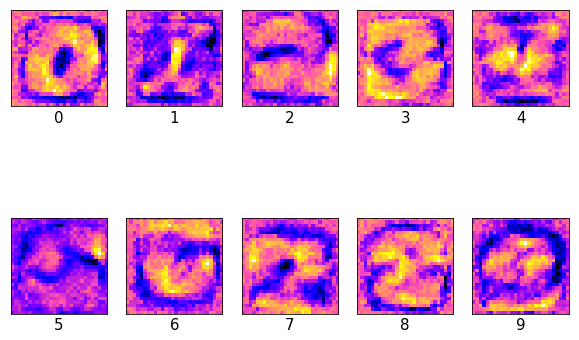

In [50]:
trans_weights = tf.transpose(weights[0])
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
for i in range(10):
  plot = np.asarray(trans_weights[i]).reshape(28,28)
  ax = plt.subplot(2,5,i+1)
  plt.imshow(plot,cmap='gnuplot2')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(i, fontsize=15)